**Домашнее задание №3**

В качестве датасета будут использоваться данные проекта Sentiment140 ( http://help.sentiment140.com/ ). 

Данный проект представляет собой 2 датасета постов с твитами, где для каждого поста была указана его эмоциональная окраска (тональность): в одном датасете вручную, в другом -- автоматически. Сам проект (алгоритмы автоматического определения тональности) не является открытым, но датасеты с реальными твитами, для которых была определена тональность, есть в открытом доступе ( http://help.sentiment140.com/for-students/ ).

In [1]:
import pandas as pd
import datetime
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm

%matplotlib inline

In [63]:
cols = ['sentiment', 'id', 'datetime', 'query_tag', 'username', 'text']
# tweets = pd.read_csv('data/training_data.csv',
#                      encoding='latin-1', header=None, names=cols, parse_dates=['datetime'])
tweets = pd.read_csv('data/manual_training_data.csv',
                     encoding='latin-1', header=None, names=cols, parse_dates=['datetime'])

In [64]:
tweets.head(10)

,sentiment,id,datetime,query_tag,username,text
0,4,3,2009-05-11 03:17:40,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,2009-05-11 03:18:03,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,2009-05-11 03:18:54,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,2009-05-11 03:19:04,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,2009-05-11 03:21:41,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
5,4,8,2009-05-11 03:22:00,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...
6,0,9,2009-05-11 03:22:30,aig,Seth937,Fuck this economy. I hate aig and their non lo...
7,4,10,2009-05-11 03:26:10,jquery,dcostalis,Jquery is my new best friend.
8,4,11,2009-05-11 03:27:15,twitter,PJ_King,Loves twitter
9,4,12,2009-05-11 03:29:20,obama,mandanicole,how can you not love Obama? he makes jokes abo...


In [65]:
tweets.shape

(498, 6)

In [66]:
tweets.loc[0]

sentiment                                                    4
id                                                           3
datetime                                   2009-05-11 03:17:40
query_tag                                              kindle2
username                                                tpryan
text         @stellargirl I loooooooovvvvvveee my Kindle2. ...
Name: 0, dtype: object

Датасет имеет 6 признаков:
    * тональность твита (0 = отрицательная, 2 = нейтральная, 4 = положительная)
    * id твита
    * дата и время создания твита
    * запрос, ключевое слово для твита, или NO_QUERY если ключевое слово не определено
    * username пользователя, создавшего твит
    * текст твита с удаленными эмоджи
    
Существует способ автоматически указать тональности твитов ( https://github.com/guyz/twitter-sentiment-dataset ), если есть зарегистрированное приложение в Twitter API, но при создании приложения, с указанием целей проекта (учебная, изучение связи тональности твита в зависимости от веремени), в создании приложения мне было отказано -- 'Your Twitter developer account application was not approved. Thank you for your interest in developer access. We are unable to serve your use case at this time.' :) Поэтому был выбран готовый датасет из Sentiment 140, так как в нем уже выставлены тональности для твитов.
    
Как пишут авторы проекта ( https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf ), датасет представляет собой 5 признаков, оставленных после получения данных с помощью Twitter API, где из самого текста твита были удалены эмоджи.

Проект состоит из 2 датасетов, в одном тональность для постов была размечена вручную, поэтому он довольно небольшой -- 500 твитов, в другом автоматически -- датасет из 1.600.000 твитов.

Нейтрально окрашенным постом, авторы предлагают считать твиты, тексты которых можно было бы использовать в качестве заголовок газет или предложений из Википедии.

Я буду рассматривать датасет, в котором тональность для твитов была выставлена вручную, а для построения предсказания временнного ряда датасет, размеченный автоматически, так как в первом датасете данные только за 23 дня и предсказание временного ряда получается не очень хорошим.

*Цель проекта*: изучить взаимосвязь между временем публикации поста и его тональностью, предсказать количество твитов на следующие 2 недели.

Пример, почему это может быть актуально:

Предположим, если есть какие-либо "счастливые часы" или "счастливые дни недели", а мы владельцы какого-либо продукта, и если, например, сообщать о новостях именно в это "счастливое" время, то получим больше положительных отзывов, а, как следствие, заказов/продаж нашего продукта.

In [67]:
tweets.sentiment.value_counts()

4    182
0    177
2    139
Name: sentiment, dtype: int64

In [68]:
tweets.columns

Index(['sentiment', 'id', 'datetime', 'query_tag', 'username', 'text'], dtype='object')

Предобработка данных.

Для анализа будут нужны колонки 'sentiment', 'datetime' и, возможно, 'query_tag':

In [69]:
tweets = tweets.drop(['id', 'username', 'text'], axis=1)
tweets.head(10)

,sentiment,datetime,query_tag
0,4,2009-05-11 03:17:40,kindle2
1,4,2009-05-11 03:18:03,kindle2
2,4,2009-05-11 03:18:54,kindle2
3,4,2009-05-11 03:19:04,kindle2
4,4,2009-05-11 03:21:41,kindle2
5,4,2009-05-11 03:22:00,kindle2
6,0,2009-05-11 03:22:30,aig
7,4,2009-05-11 03:26:10,jquery
8,4,2009-05-11 03:27:15,twitter
9,4,2009-05-11 03:29:20,obama


Для поставленной задачи в некоторых случаях время удобнее рассматривать в виде date, time колонок

In [70]:
tweets['date'] = tweets['datetime'].dt.date
tweets['time'] = tweets['datetime'].dt.time

In [71]:
tweets.head(10)

,sentiment,datetime,query_tag,date,time
0,4,2009-05-11 03:17:40,kindle2,2009-05-11,03:17:40
1,4,2009-05-11 03:18:03,kindle2,2009-05-11,03:18:03
2,4,2009-05-11 03:18:54,kindle2,2009-05-11,03:18:54
3,4,2009-05-11 03:19:04,kindle2,2009-05-11,03:19:04
4,4,2009-05-11 03:21:41,kindle2,2009-05-11,03:21:41
5,4,2009-05-11 03:22:00,kindle2,2009-05-11,03:22:00
6,0,2009-05-11 03:22:30,aig,2009-05-11,03:22:30
7,4,2009-05-11 03:26:10,jquery,2009-05-11,03:26:10
8,4,2009-05-11 03:27:15,twitter,2009-05-11,03:27:15
9,4,2009-05-11 03:29:20,obama,2009-05-11,03:29:20


In [72]:
tweets = tweets.sort_values('date', ascending=True)

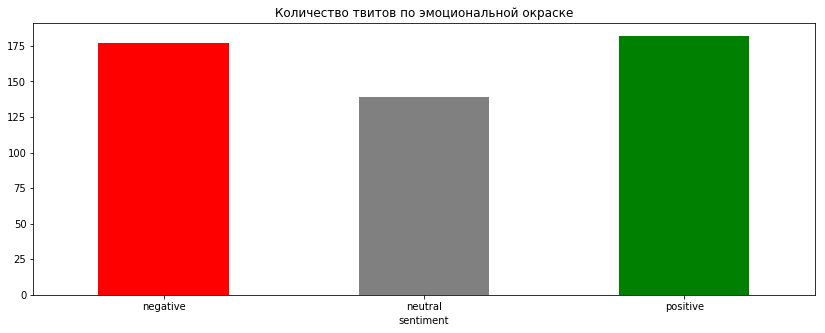

In [73]:
df = pd.DataFrame({'sentiment':['negative', 'neutral', 'positive'],
                   'count': tweets.sentiment.value_counts().sort_index()})
ax = df.plot.bar(x='sentiment', y='count', rot=0, legend=False,
                 figsize= (14,5), title='Количество твитов по эмоциональной окраске',
                 color= ['red', 'gray', 'green'])

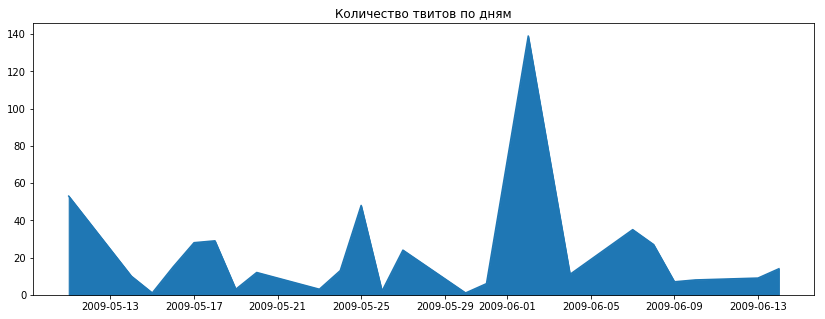

In [74]:
tweets.date.value_counts().plot.area(figsize= (14,5), title='Количество твитов по дням')

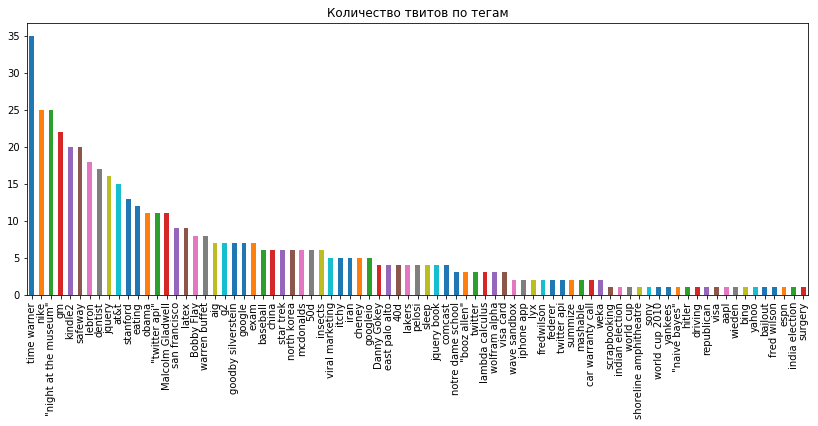

In [75]:
tweets.query_tag.value_counts().plot.bar(figsize= (14,5), title='Количество твитов по тегам')

In [76]:
popular_tags = tweets.query_tag.value_counts().index[:15].tolist()
popular_tags

['time warner',
 'nike',
 '"night at the museum"',
 'gm',
 'kindle2',
 'safeway',
 'lebron',
 'dentist',
 'jquery',
 'at&t',
 'stanford',
 'eating',
 'obama',
 '"twitter api"',
 'Malcolm Gladwell']

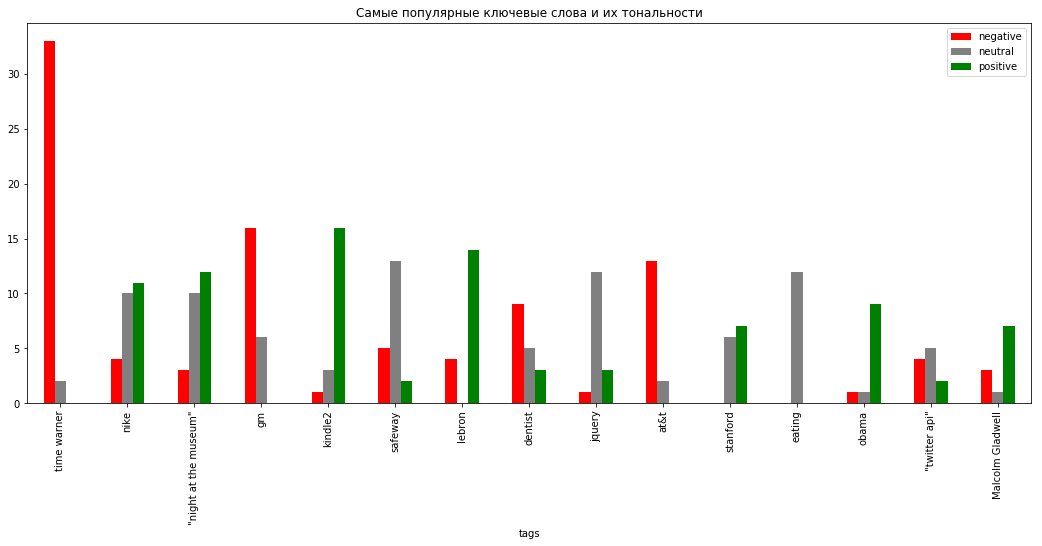

In [77]:
is_neg = []
is_neu = []
is_pos = []

for tag in popular_tags:
    is_neg.append(tweets[(tweets['query_tag'] == tag) & (tweets['sentiment'] == 0)].shape[0])
    is_neu.append(tweets[(tweets['query_tag'] == tag) & (tweets['sentiment'] == 2)].shape[0])
    is_pos.append(tweets[(tweets['query_tag'] == tag) & (tweets['sentiment'] == 4)].shape[0])
df = pd.DataFrame({'tags': popular_tags,
                  'negative': is_neg,
                   'neutral': is_neu,
                   'positive': is_pos})
ax = df.plot.bar(x='tags',
                 figsize= (18,7), title='Самые популярные ключевые слова и их тональности',
                 color= ['red', 'gray', 'green'])

У самого популярного тега 'time warner' типичный твит окрашен негативно, 
а самый положительно окрашенный твит ('kindle2') имеет более чем в 2 раза меньше упоминаний.

Рассмотрим, в какой день недели делали больше всего твитов

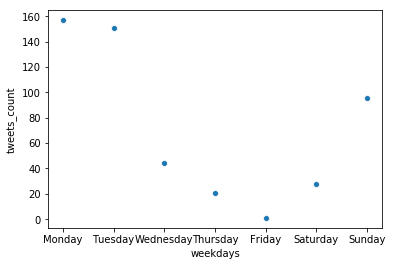

In [17]:
sorter = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
week_summary = tweets['datetime'].dt.weekday_name.value_counts()
count = []
for day in sorter:
    count.append(week_summary[day])
    
df = pd.DataFrame({'weekdays': sorter,
                  'tweets_count': count})
import seaborn as sns
sns.scatterplot(x='weekdays', y='tweets_count', data=df)

Из графика видно, что чаще всего твиты появляются в промежутке с воскресенья по вторник.

Рассмотрим зависимость дня недели и времени суток

/Users/irina/homebrew/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


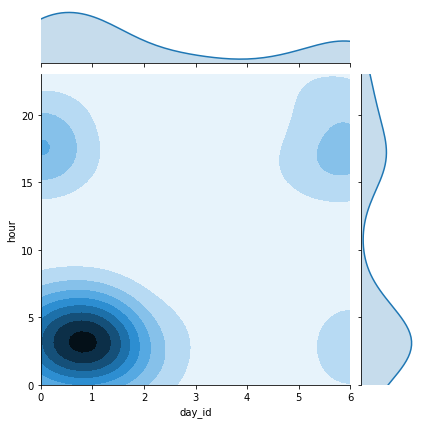

In [18]:
sorter = {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
tweets['day_id'] = tweets['datetime'].dt.weekday_name.map(sorter)
tweets['hour'] = tweets['datetime'].dt.hour
sns.jointplot(x='day_id', y='hour', data=tweets, kind = 'kde', ylim=(0, 23), xlim=(0,6))

Таким образом, можно заключить, что люди чаще пишут в первой половине недели, в первой половине дня,
и максимум наблюдаетя во вторник в 3-4 часа утра.

Зависимость положительно окрашенных твитов от времени суток и недели:

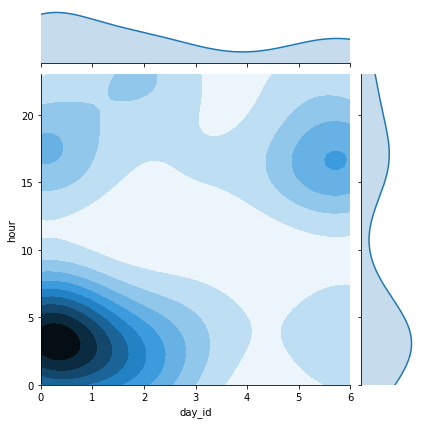

In [19]:
sns.jointplot(x='day_id', y='hour', data=tweets[tweets['sentiment']==4], kind = 'kde', ylim=(0, 23), xlim=(0,6))

Зависимость отрицательно окрашенных твитов от времени суток и недели:

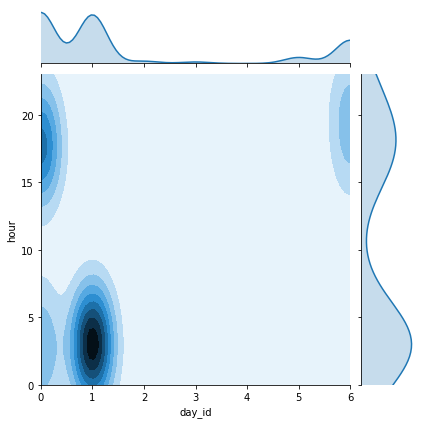

In [20]:
sns.jointplot(x='day_id', y='hour', data=tweets[tweets['sentiment']==0], kind = 'kde', ylim=(0, 23), xlim=(0,6))

Из последних двух графиков можно заключить, что если выбирать день недели, то твит, опубликованный во вторник,
будет с большей вероятностью отрицательно окрашен, чем твит, опубликованный в понедельник. Но также это может
быть обусловлено просто большим количеством твитов по вторникам, чем в какие-либо другие дни.

То есть явной зависимости между днями недели и временем суток в оценке тональности твитов в данном датасете
выявить на глаз не удается.

*Проверка статистических гипотез:*

In [21]:
from scipy import stats

Модифицируем датасет для удобной работы:

In [22]:
ttweets = pd.DataFrame({'date': tweets.date.value_counts().index,
                          'tweets': tweets.date.value_counts().values})
ttweets.shape

(23, 2)

Проверим распределение на нормальность с помощью критерия Шапиро-Уилка:

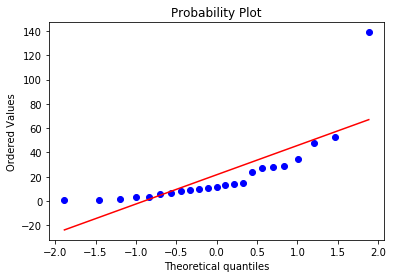

In [23]:
stats.probplot(ttweets.tweets, dist = "norm", plot = plt)
plt.show()

In [24]:
stats.shapiro(ttweets.tweets)

(0.6361070871353149, 2.3049640276440186e-06)

То есть гипотеза о том, что наше распределение нормально, не верна.

Судя по графику плотности (третий по порядку из графиков плотности), на вторник приходится максимум как вообще твитов, так и отрицательно окрашенных твитов. Проверим гипотезу о том, что доля отрицательно окрашенных твитов во вторник, такая же как и в другие дни.

H0: доля отрицательно окрашенных комментариев вторник равна доле отрицательно-окрашенных комментариев во все другие дни

H1: доля отрицательно окрашенных комментариев вторник больше доли отрицательно-окрашенных комментариев во все другие дни

In [25]:
beg_pos_count = tweets[((tweets['sentiment'] == 0) & (tweets['day_id'].isin([1])))].shape[0]
beg_count = tweets[tweets['day_id'].isin([1])].shape[0]
end_pos_count = tweets[((tweets['sentiment'] == 0) & (tweets['day_id'].isin([0,2,3,4,5,6])))].shape[0]
end_count = tweets[tweets['day_id'].isin([0,6,2,3,4,5])].shape[0]

In [26]:
from statsmodels.stats.proportion import proportions_ztest
beg_frac = np.array([beg_pos_count, beg_count])
print(beg_frac)
end_frac = np.array([end_pos_count, end_count])
print(end_frac)
proportions_ztest(beg_frac, end_frac, alternative='larger')

[ 65 151]
[112 347]


(2.676779711580878, 0.0037166745108370824)

Гипотеза H0 опровергнута, значит, во вторник отрицательных твитов в среднем бывает больше, чем в другие дни.

In [27]:
ttweets.head(15)

,date,tweets
0,2009-06-02,139
1,2009-05-11,53
2,2009-05-25,48
3,2009-06-07,35
4,2009-05-18,29
5,2009-05-17,28
6,2009-06-08,27
7,2009-05-27,24
8,2009-05-16,15
9,2009-06-14,14


Проверим гипотезу о том, что количество твитов в день равно 25:

In [28]:
from statsmodels.stats.descriptivestats import sign_test
sign_test(ttweets.tweets, 25)

(-4.5, 0.09313964843749999)

Гипотеза H0 верна.

*Временные ряды:*

Попытаемся предсказать количество постов, если известно количество постов за предыдущие дни

Модифицируем датасет для удобной работы:

In [29]:
ttweets = pd.DataFrame({'date': tweets.date.value_counts().index,
                          'tweets': tweets.date.value_counts().values})
ttweets.shape

(23, 2)

Он очень мал для предсказания временного ряда, рассмотрю датасет размеченный автоматически из того же проекта,
графики описанные выше, касающиеся тегов и разметок тональностей остаются справедливыми, так как у автоматически размеченного датасета не заполнены поля query_tag, и не может быть (согласно статье, упомянутой выше) нейтрально окрашенных постов, а положительно и отрицательно окрашенных постов -- ровно по половине датасета. Признаки у этого датасета такие же, как описано в начале.

In [30]:
ttweets = pd.read_csv('data/training_data.csv',
                     encoding='latin-1', header=None, names=cols, parse_dates=['datetime'])

/Users/irina/homebrew/lib/python3.7/site-packages/dateutil/parser/_parser.py:1204: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [31]:
ttweets.head()

,sentiment,id,datetime,query_tag,username,text
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [32]:
ttweets.shape

(1600000, 6)

Одинаковое количество отрицательно и положительно окрашенных постов:

In [33]:
ttweets.sentiment.value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

Нет тегов:

In [34]:
ttweets.query_tag.value_counts()

NO_QUERY    1600000
Name: query_tag, dtype: int64

Предобработка:

In [35]:
ttweets['date'] = ttweets['datetime'].dt.date
ttweets.head()

,sentiment,id,datetime,query_tag,username,text,date
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",2009-04-06
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,2009-04-06
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,2009-04-06
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,2009-04-06
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",2009-04-06


In [36]:
ttweets = ttweets.drop(['id', 'username', 'text', 'query_tag', 'sentiment', 'datetime'], axis=1)
ttweets.head(10)

,date
0,2009-04-06
1,2009-04-06
2,2009-04-06
3,2009-04-06
4,2009-04-06
5,2009-04-06
6,2009-04-06
7,2009-04-06
8,2009-04-06
9,2009-04-06


In [37]:
tweets = pd.DataFrame({'date': ttweets.date.value_counts().index,
                          'tweets': ttweets.date.value_counts().values})
tweets.shape

(48, 2)

Оказалось, что 1.600.000 твитов из датасета были собраны всего за 48 дней, что, конечно, тоже плохо, но все же лучше, чем 23 дня.

In [38]:
tweets.date.sort_values(ascending=True)

42    2009-04-06
26    2009-04-07
43    2009-04-17
22    2009-04-18
19    2009-04-19
24    2009-04-20
35    2009-04-21
38    2009-05-01
20    2009-05-02
18    2009-05-03
30    2009-05-04
32    2009-05-09
21    2009-05-10
40    2009-05-11
41    2009-05-13
25    2009-05-14
34    2009-05-16
15    2009-05-17
17    2009-05-18
44    2009-05-21
16    2009-05-22
46    2009-05-23
47    2009-05-25
33    2009-05-26
45    2009-05-27
29    2009-05-28
6     2009-05-29
3     2009-05-30
5     2009-05-31
1     2009-06-01
8     2009-06-02
14    2009-06-03
37    2009-06-04
9     2009-06-05
0     2009-06-06
4     2009-06-07
36    2009-06-14
2     2009-06-15
7     2009-06-16
11    2009-06-17
13    2009-06-18
12    2009-06-19
10    2009-06-20
28    2009-06-21
31    2009-06-22
27    2009-06-23
39    2009-06-24
23    2009-06-25
Name: date, dtype: object

В датасете есть даты, о которых нет информации о количестве твитов в этот день. Буду полагать, что твитов в это было столько же, сколько в среднем по всему датасету.

In [39]:
import datetime
tweets.index = tweets.date
tweets = tweets.sort_values('date', ascending = True)
mean_tweets = tweets.tweets.mean()

idx = pd.date_range('2009-04-06', '2009-06-25')
row_list = []
for date in idx:
    if date.date() not in tweets.index:
        dict1 = {'date': date.date(), 'tweets': mean_tweets}
        row_list.append(dict1)
df = pd.DataFrame(row_list)
df.index = df.date
df.shape
ex_tweets = pd.concat([tweets,df])
ex_tweets = ex_tweets.sort_values('date', ascending = True)
ex_tweets.head()

/Users/irina/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/irina/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  app.launch_new_instance()


,date,tweets
date,,
2009-04-06,2009-04-06,3360.000000
2009-04-07,2009-04-07,17311.000000
2009-04-08,2009-04-08,33333.333333
2009-04-09,2009-04-09,33333.333333
2009-04-10,2009-04-10,33333.333333


In [40]:
ex_tweets.shape

(81, 2)

Разделим выборку:

In [41]:
train = ex_tweets.iloc[:-14]
test = ex_tweets.iloc[-14:]

,date,tweets
date,,
2009-04-06,2009-04-06,3360.000000
2009-04-07,2009-04-07,17311.000000
2009-04-08,2009-04-08,33333.333333
2009-04-09,2009-04-09,33333.333333
2009-04-10,2009-04-10,33333.333333


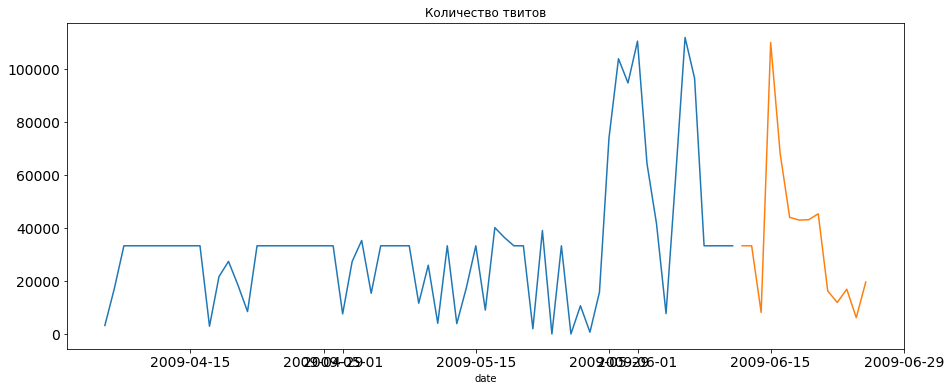

In [42]:
train.tweets.plot(figsize=(15,6),title= 'Количество твитов', fontsize=14)
test.tweets.plot(figsize=(15,6),title= 'Количество твитов', fontsize=14)

train.head()

Оказалось, что sm.tsa.seasonal_decompose не работает с индексами типа date, но работает с datetime

In [43]:
pd.to_datetime(ex_tweets['date'])
ex_tweets.index = pd.to_datetime(ex_tweets.index)

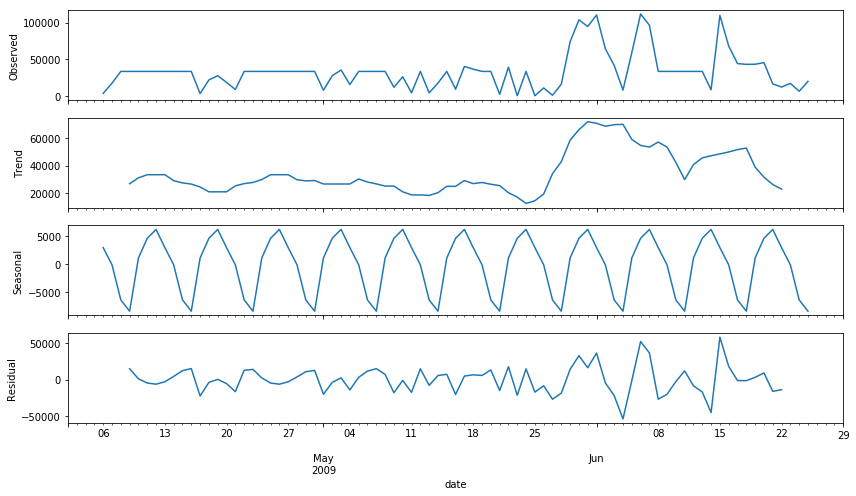

In [44]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 7
sm.tsa.seasonal_decompose(ex_tweets.tweets).plot()
plt.show()

Автокорреляция:

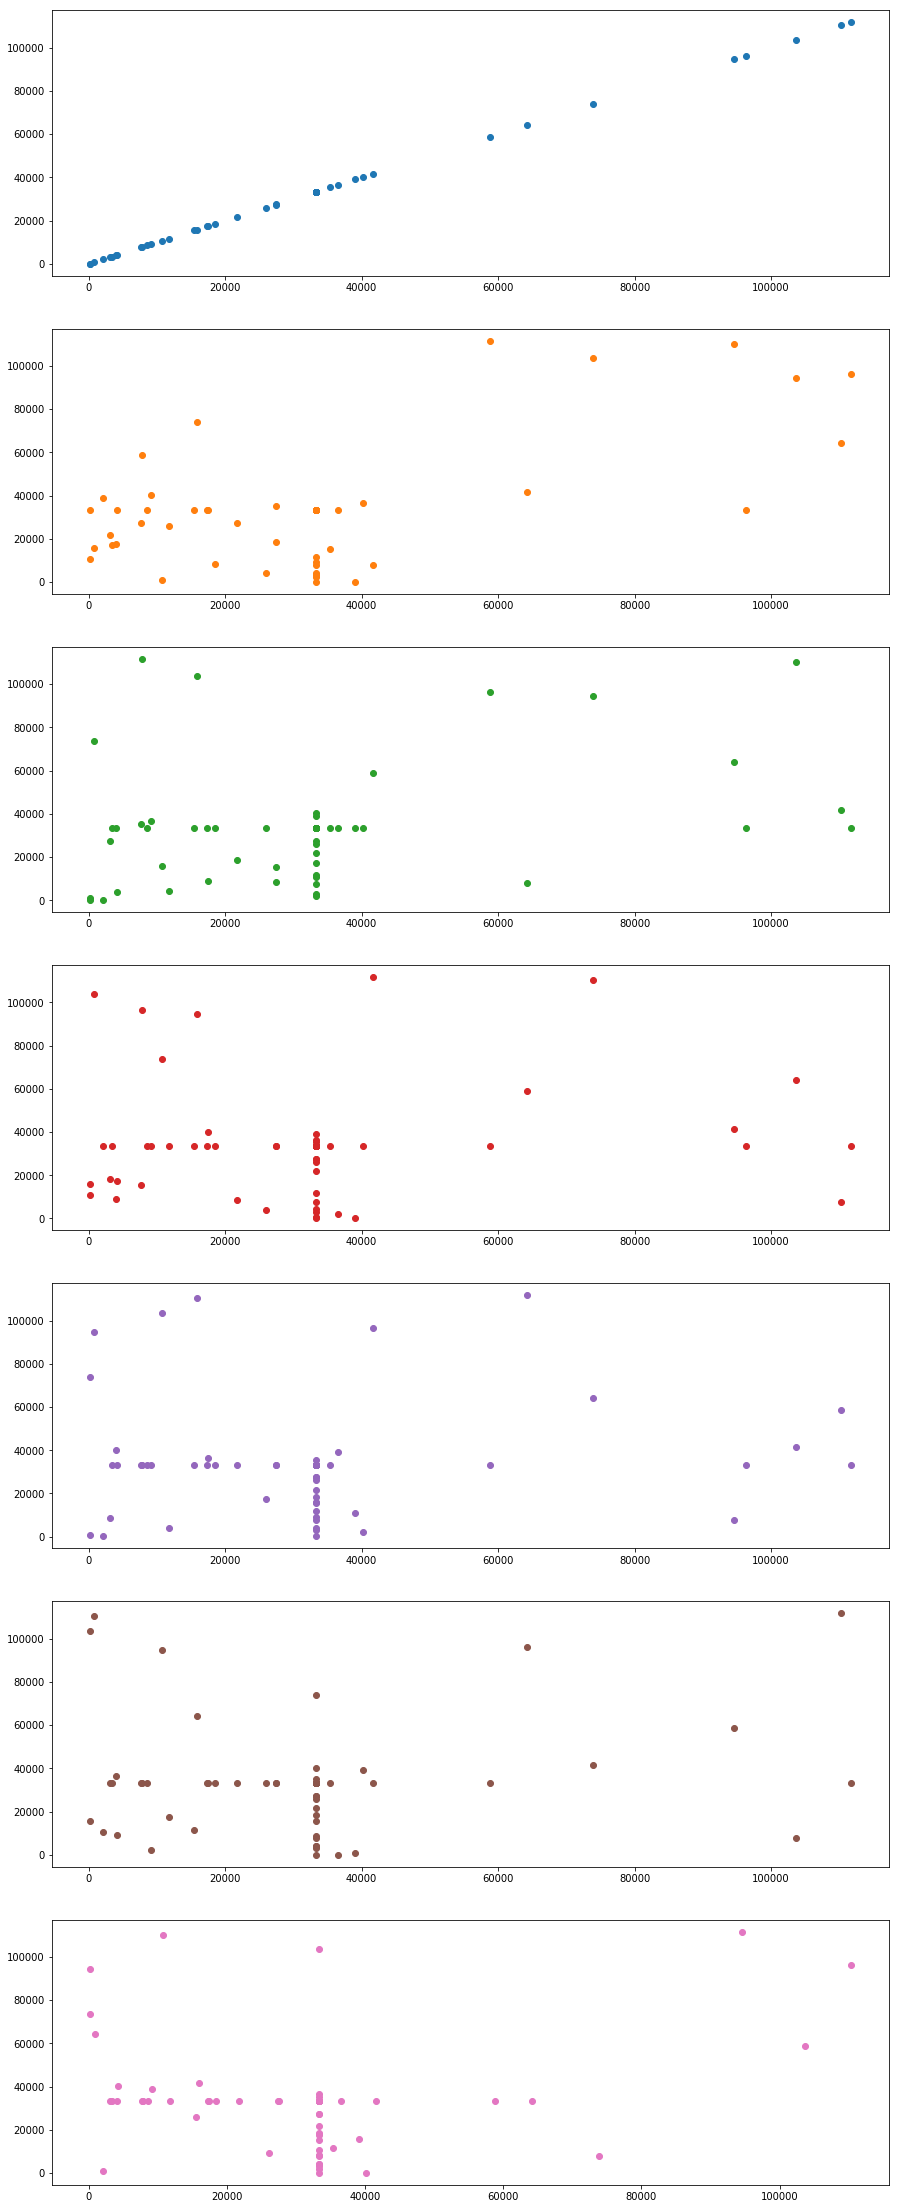

In [45]:
fig, axes = plt.subplots(7,1,figsize = (15,40))
for k, ax in enumerate(axes):
    for i in range(k):
        next(ax._get_lines.prop_cycler)
    ax.plot(train.tweets,train.tweets.shift(-k),'o')


plt.show()

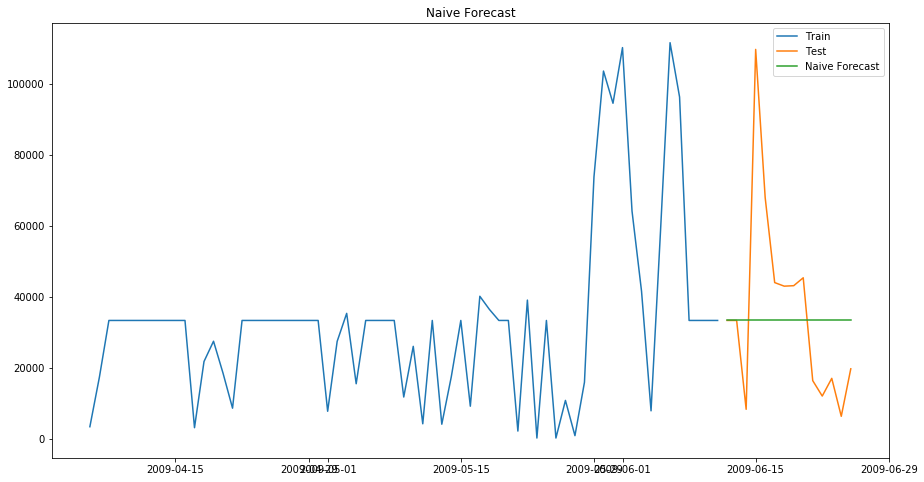

In [46]:
y_hat = test.copy()
y_hat['naive'] = train.tweets[-1]

plt.figure(figsize=(15,8))
plt.plot(train.index, train.tweets, label='Train')
plt.plot(test.index,test.tweets, label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [47]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.tweets, y_hat.naive))
print(rms)

26789.54071710326


Экспоненциальное сглаживание

In [48]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

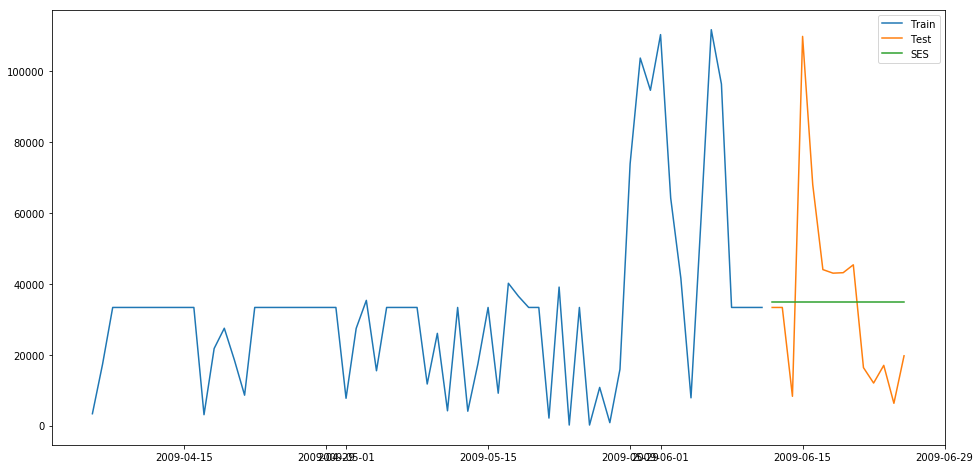

In [49]:
fit2 = SimpleExpSmoothing(np.asarray(train.tweets)).fit(smoothing_level=0.6,optimized=False)
y_hat['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train.tweets, label='Train')
plt.plot(test.tweets, label='Test')
plt.plot(y_hat['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [50]:
rms = sqrt(mean_squared_error(test.tweets, y_hat.SES))
print(rms)

26699.68768405099


Метод линейного тренда Холта-Уинтерса

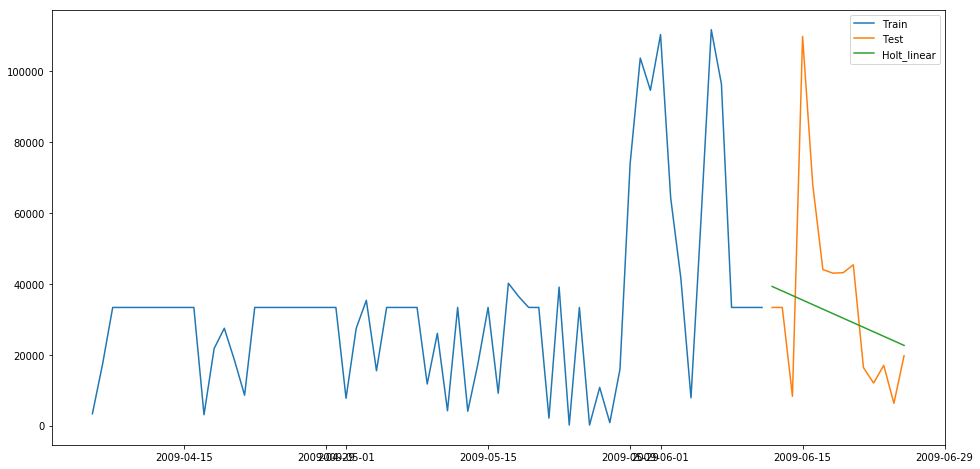

In [51]:
fit1 = Holt(np.asarray(train.tweets)).fit(smoothing_level = 0.4,smoothing_slope = 0.1)
y_hat['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train.tweets, label='Train')
plt.plot(test.tweets, label='Test')
plt.plot(y_hat['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [52]:
rms = sqrt(mean_squared_error(test.tweets, y_hat.Holt_linear))
print(rms)

25284.659297788974


Метод Холта-Уинтерса

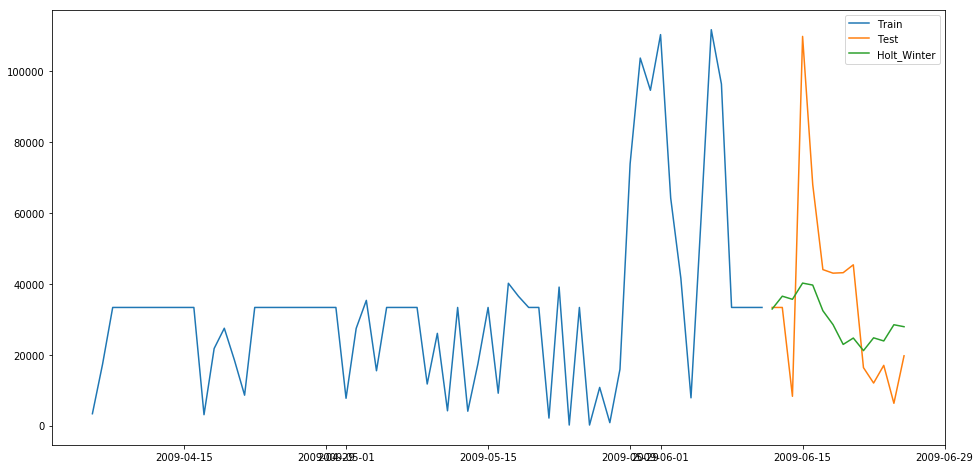

In [53]:
fit1 = ExponentialSmoothing(np.asarray(train.tweets),
                            seasonal_periods=9,
                            trend='add',
                            seasonal='add').fit(smoothing_level = 0.5,smoothing_slope = 0.1)
y_hat['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train.tweets, label='Train')
plt.plot(test.tweets, label='Test')
plt.plot(y_hat['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [54]:
rms = sqrt(mean_squared_error(test.tweets, y_hat.Holt_Winter))
print(rms)

24459.072134352547


ARIMA

In [55]:
test_ = sm.tsa.adfuller(train.tweets)
print ('adf: ', test_[0] )
print ('p-value: ', test_[1])
print('Critical values: ', test_[4])
if test_[0]> test_[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -4.202523820907742
p-value:  0.0006524484474013112
Critical values:  {'1%': -3.5335601309235605, '5%': -2.9064436883991434, '10%': -2.590723948576676}
единичных корней нет, ряд стационарен


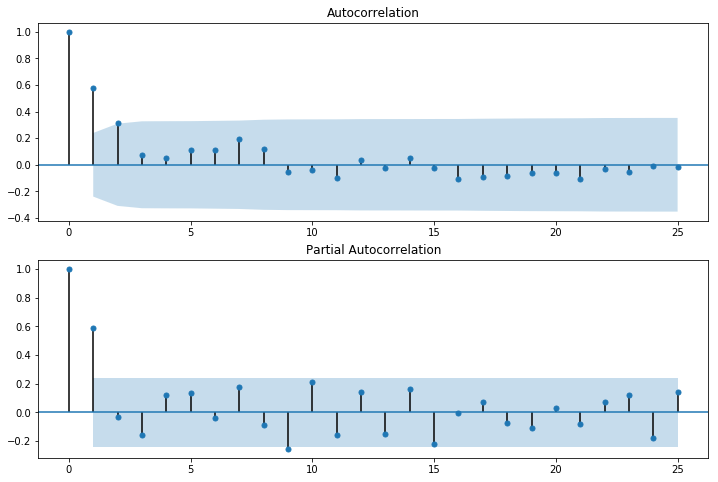

In [56]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train.tweets.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train.tweets, lags=25, ax=ax2)

In [57]:
#ACF
q = 2
Q = 1

#PACF
p = 1
P = 0

d = 0
D = 1

s = 9

In [58]:
best_model=sm.tsa.statespace.SARIMAX(train.tweets.squeeze(), order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit()

/Users/irina/homebrew/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [59]:
stat_test = sm.tsa.adfuller(best_model.resid[20:])
print ('adf: ', stat_test[0] )
print ('p-value: ', stat_test[1])
print('Critical values: ', stat_test[4])
if stat_test[0]> stat_test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -6.897094200351048
p-value:  1.310420575365651e-09
Critical values:  {'1%': -3.5812576580093696, '5%': -2.9267849124681518, '10%': -2.6015409829867675}
единичных корней нет, ряд стационарен


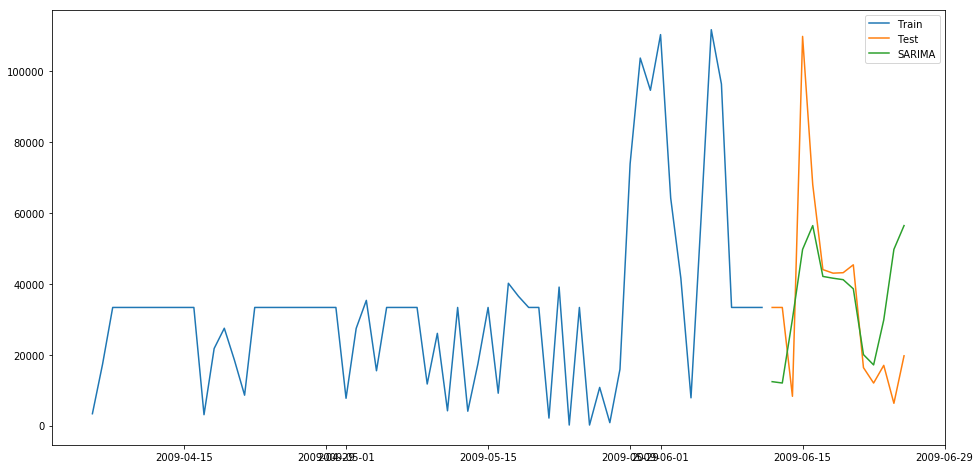

In [60]:
forecast = best_model.predict(start = train.shape[0], end = train.shape[0]+14)
y_hat['SARIMA'] = forecast
plt.figure(figsize=(16,8))
plt.plot(train.tweets, label='Train')
plt.plot(test.tweets, label='Test')
plt.plot(y_hat['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [61]:
rms = sqrt(mean_squared_error(test.tweets, y_hat.SARIMA))
print(rms)

24788.97814632404


Выводы:
* Количество упоминаний некоторого тега в твите это не всегда хорошо, из графиков можно наблюдать, что самый популярный тег относится к твитам с чаще всего отрицательной окраской
* Твит опубликованный во вторник будет более вероятно являтся отрицательно-окрашенным, чем твит в любой другой день.
* Люди чаще пишут твиты в начале недели и в выходные, на среду-четверг-пятницу приходится меньшее количество твитов
* В качестве периода сезонности для улучшения оценки ошибок оказалось лучше брать 9 дней, а не 7.
* Оценка ошибок при подборе параметров seasonal_periods, smoothing_level ,smoothing_slope в методе Холта-Уинтерса оказалась лучше, чем в ARIMA